In [1]:
from jetutils.definitions import *
from jetutils.data import *
from jetutils.jet_finding import *
from jetutils.anyspell import *
from jetutils.plots import *

%load_ext IPython.extensions.autoreload
%autoreload 2
%matplotlib inline

Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  10
Guessed MEMORY_LIMIT :  102400


IPython could not be loaded!


In [2]:
run = "ctrl"

dh = DataHandler.from_specs("Henrik_data", run, ("high_wind", ["u", "v", "s", "theta", "lev"]), "6H", minlon=-80, maxlon=40, minlat=15, maxlat=80)
exp = JetFindingExperiment(dh)
basepath_ctrl = exp.path
exp.find_jets(force=False, n_coarsen=1, smooth_s=5, alignment_thresh=0.55, base_s_thresh=0.55, int_thresh_factor=0.2, hole_size=5)
all_jets_one_df = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=15, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})
props_uncat = exp.props_as_df(categorize=False).rename({"lon": "mean_lon"}).cast({"time": pl.Datetime("ms")})

all_times = props_uncat["time"].unique().sort().to_frame()
summer_filter = (
    all_times
    .filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
    .filter(pl.col("time").dt.ordinal_day() > 166)
)
summer = summer_filter["time"]
summer_daily = summer.filter(summer.dt.hour() == 0)
big_summer = all_times.filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
big_summer_daily = big_summer.filter(big_summer["time"].dt.hour() == 0)

phat_filter = (pl.col("is_polar") < 0.5) | ((pl.col("is_polar") > 0.5) & (pl.col("int") > 1.e8))
phat_jets = all_jets_one_df.filter((pl.col("is_polar").mean().over(["time", "jet ID"]) < 0.5) | ((pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5) & (pl.col("int").mode().first().over(["time", "jet ID"]) > 1.e8)))

jets_ctrl = phat_jets.with_columns(**{"jet ID": (pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5).cast(pl.UInt32())})
phat_props = props_uncat.filter(phat_filter)
phat_props_catd = average_jet_categories(phat_props, polar_cutoff=0.5)
phat_props_catd = phat_props_catd.join(phat_props_catd.rolling("time", period="2d", group_by="jet").agg(**{f"{col}_var": pl.col(col).var() for col in ["mean_lon", "mean_lat", "mean_s", "s_star"]}), on=["time", "jet"])
props_ctrl = phat_props_catd.clone()
props_summer_ctrl = summer_filter.join(props_ctrl, on="time")

opath_cross_ctrl = basepath_ctrl.joinpath("cross_catd.parquet")
if opath_cross_ctrl.is_file():
    cross_catd_ctrl = pl.read_parquet(opath_cross_ctrl)
else:
    cross_catd_ctrl = track_jets(jets_ctrl, n_next=1)
    cross_catd_ctrl.write_parquet(opath_cross_ctrl)
    
spells_list_ctrl = spells_from_cross_catd(cross_catd_ctrl, season=summer, q_STJ=0.9, q_EDJ=0.54, minlen=datetime.timedelta(days=4))

for name, spell in spells_list_ctrl.items():
    print(name, spell["spell"].n_unique())
daily_spells_list_ctrl = {a: make_daily(b, "spell", ["len", "spell_of"]) for a, b in spells_list_ctrl.items()}

STJ 20
EDJ 20


In [3]:
run = "dobl"

dh = DataHandler.from_specs("Henrik_data", run, ("high_wind", ["u", "v", "s", "theta", "lev"]), "6H", minlon=-80, maxlon=40, minlat=15, maxlat=80)
exp = JetFindingExperiment(dh)
basepath_dobl = exp.path
exp.find_jets(force=False, n_coarsen=1, smooth_s=5, alignment_thresh=0.55, base_s_thresh=0.55, int_thresh_factor=0.2, hole_size=5)
all_jets_one_df = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=15, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})
props_uncat = exp.props_as_df(categorize=False).rename({"lon": "mean_lon"}).cast({"time": pl.Datetime("ms")})

all_times = props_uncat["time"].unique().sort().to_frame()
summer_filter = (
    all_times
    .filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
    .filter(pl.col("time").dt.ordinal_day() > 166)
)
summer = summer_filter["time"]
summer_daily = summer.filter(summer.dt.hour() == 0)
big_summer = all_times.filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
big_summer_daily = big_summer.filter(big_summer["time"].dt.hour() == 0)

phat_filter = (pl.col("is_polar") < 0.5) | ((pl.col("is_polar") > 0.5) & (pl.col("int") > 1.e8))
phat_jets = all_jets_one_df.filter((pl.col("is_polar").mean().over(["time", "jet ID"]) < 0.5) | ((pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5) & (pl.col("int").mode().first().over(["time", "jet ID"]) > 1.e8)))

jets_dobl = phat_jets.with_columns(**{"jet ID": (pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5).cast(pl.UInt32())})
phat_props = props_uncat.filter(phat_filter)
phat_props_catd = average_jet_categories(phat_props, polar_cutoff=0.5)
phat_props_catd = phat_props_catd.join(phat_props_catd.rolling("time", period="2d", group_by="jet").agg(**{f"{col}_var": pl.col(col).var() for col in ["mean_lon", "mean_lat", "mean_s", "s_star"]}), on=["time", "jet"])
props_dobl = phat_props_catd.clone()
props_summer_dobl = summer_filter.join(props_dobl, on="time")

opath_cross_dobl = basepath_dobl.joinpath("cross_catd.parquet")
if opath_cross_dobl.is_file():
    cross_catd_dobl = pl.read_parquet(opath_cross_dobl)
else:
    cross_catd_dobl = track_jets(jets_dobl, n_next=1)
    cross_catd_dobl.write_parquet(opath_cross_dobl)
    
spells_list_dobl = spells_from_cross_catd(cross_catd_dobl, season=summer, q_STJ=0.895, q_EDJ=0.53, minlen=datetime.timedelta(days=4))

for name, spell in spells_list_dobl.items():
    print(name, spell["spell"].n_unique())
daily_spells_list_dobl = {a: make_daily(b, "spell", ["len", "spell_of"]) for a, b in spells_list_dobl.items()}

STJ 20
EDJ 20


In [4]:
long_names = {
    "theta": r"$\theta$",
    "z": "500 hPa $z$",
    "DTCOND": "Diabatic tendencies",
    "PTTEND": r"$\theta$ tendencies",
}

factors = {
    "theta": 1,
    "z": 1,
    "DTCOND": 1e9,
    "PTTEND": 1e6,
}

units = {
    "theta": "K",
    "z": "m",
    "DTCOND": r"$10^{-9}$ J/s",
    "PTTEND": r"$10^{-6}$ K/s",
}

variables = {
    "theta:clim": [6, colormaps.amp, [330, 370]],
    "theta:anom": [8, colormaps.BlWhRe, [-4, 4]],
    "theta:clim_grad": [8, colormaps.BlWhRe, [-4, 4]],
    "theta:anom_grad": [8, colormaps.BlWhRe, [-2, 2]],
    "z:clim": [9, colormaps.amp, [5000, 6000]],
    "z:anom": [8, colormaps.BlWhRe, [-150, 150]],
    "DTCOND:clim": [8, colormaps.amp, [0, 1.]],
    "DTCOND:anom": [8, colormaps.BlWhRe, [-.5, .5]],
    "PTTEND:clim": [6, colormaps.amp, [280, 300]],
    "PTTEND:anom": [8, colormaps.BlWhRe, [-4, 4]],
}

all_spells = {f"{exp_}_{jet}": dico[jet] for jet in ["STJ", "EDJ"] for exp_, dico in {"ctrl": spells_list_ctrl, "dobl": spells_list_dobl}.items()}
vars_ = ["DTCOND", "PTTEND", "theta", "z"]
summer_doy = summer_daily.dt.ordinal_day().unique()

def compute_relative_clim(df, varname): 
    return df.group_by(pl.col("time").dt.ordinal_day().alias("dayofyear"), "norm_index", "n", "is_polar").agg(pl.col(f"{varname}_interp").mean()).sort("is_polar", "dayofyear", "norm_index", "n")

def compute_relative_std(df, varname): 
    return df.group_by(pl.col("time").dt.ordinal_day().alias("dayofyear"), "norm_index", "n", "is_polar").agg(pl.col(f"{varname}_interp").std()).sort("is_polar", "dayofyear", "norm_index", "n")

def compute_relative_sm(clim, varname): 
    return clim.with_columns(**{f"{varname}_interp": pl.col(f"{varname}_interp").filter(pl.col("dayofyear").is_in(summer_doy.implode())).mean().over("is_polar", "n", "norm_index")})

def try_and_load(basepath: Path, var: str, object_type: str, subtype: str, func: Callable, *args):
    opath = basepath.joinpath(f"{var}_relative_{object_type}_{subtype}.parquet")
    if opath.is_file():
        return pl.scan_parquet(opath)
    to_ret = func(*args)
    try:
        to_ret = to_ret.collect()
    except AttributeError:
        pass
    to_ret.write_parquet(opath)
    return to_ret.lazy()

def compute_anom(df, varname, clim, clim_std = None): 
    varname_ = f"{varname}_interp"
    if clim_std is None:
        return (
            df
            .with_columns(dayofyear=pl.col("time").dt.ordinal_day())
            .join(clim, on=["is_polar", "dayofyear", "norm_index", "n"])
            .with_columns(pl.col(varname_) - pl.col(f"{varname_}_right"))
            .drop(f"{varname_}_right", "dayofyear")
        )
    return (
        df
        .with_columns(dayofyear=pl.col("time").dt.ordinal_day())
        .join(clim, on=["is_polar", "dayofyear", "norm_index", "n"])
        .with_columns(pl.col(varname_) - pl.col(f"{varname_}_right"))
        .drop(f"{varname_}_right")
        .join(clim_std, on=["is_polar", "dayofyear", "norm_index", "n"])
        .with_columns(pl.col(varname_) / pl.col(f"{varname_}_right"))
        .drop(f"{varname_}_right", "dayofyear")
    )

clim_types = ["def", "std", "sm", "sstd"]
all_clims = {key: {} for key in clim_types}
anom_types = ["def", "std", "def_sm", "std_sm"]
all_anoms = {key: {} for key in anom_types}
relative_dfs = {}
basepaths = {"ctrl": basepath_ctrl, "dobl": basepath_dobl}

for exp_, var in tqdm(product(["ctrl", "dobl"], vars_), total=2 * len(vars_)):
    basepath = basepaths[exp_]
    key = f"{var}_{exp_}"
    relative_dfs[key] = pl.scan_parquet(basepath.joinpath(f"{var}_relative.parquet")).with_columns(pl.col(f"{var}_interp") * factors[var])
    
    all_clims["def"][key] = try_and_load(basepath, var, "clim", "def", compute_relative_clim, relative_dfs[key], var)
    all_clims["std"][key] = try_and_load(basepath, var, "clim", "std", compute_relative_std, relative_dfs[key], var)
    all_clims["sm"][key] = try_and_load(basepath, var, "clim", "sm", compute_relative_sm, all_clims["def"][key], var)
    all_clims["sstd"][key] = try_and_load(basepath, var, "clim", "sstd", compute_relative_sm, all_clims["std"][key], var)
    
    all_anoms["def"][key] = try_and_load(basepath, var, "anom", "def", compute_anom, relative_dfs[key], var, all_clims["def"][key])
    all_anoms["std"][key] = try_and_load(basepath, var, "anom", "std", compute_anom, relative_dfs[key], var, all_clims["def"][key], all_clims["std"][key])
    all_anoms["def_sm"][key] = try_and_load(basepath, var, "anom", "sm", compute_anom, relative_dfs[key], var, all_clims["sm"][key])
    all_anoms["std_sm"][key] = try_and_load(basepath, var, "anom", "std_sm", compute_anom, relative_dfs[key], var, all_clims["sm"][key], all_clims["sstd"][key])

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 207.38it/s]



In [42]:
exp_ = "dobl"
for exp_, jet in product(["ctrl", "dobl"], ["STJ", "EDJ"]):
    is_polar = jet == "EDJ"
    spells = all_spells[f"{exp_}_{jet}"].lazy()
    for varname, props in variables.items():
        nlevels, cmap, (min_, max_) = props
        varname, mode = varname.split(":")
        varname_ = f"{varname}_interp"
        key = f"{varname}_{exp_}"
        long_name = long_names[varname]
        grad = mode[-4:] == "grad"
        if mode in ["clim", "clim_grad"]:
            to_plot = all_clims["sm"][key].filter(pl.col("dayofyear") == 1, pl.col("is_polar") == is_polar)
            if grad:
                to_plot = to_plot.with_columns(central_diff(varname_).over("norm_index"))
            to_plot = to_plot.drop("is_polar", "dayofyear")
        else:
            to_plot = spells.join(all_anoms["def"][key], on="time").filter(pl.col("is_polar") == is_polar)
            if grad:
                to_plot = to_plot.with_columns(central_diff(varname_).over("time", "norm_index"))
            to_plot = to_plot.group_by("norm_index", "n", maintain_order=True).agg(pl.col(varname_).mean())
            to_plot = to_plot.drop("is_polar")
        to_plot = to_plot.collect()
        to_plot = polars_to_xarray(to_plot, ["norm_index", "n"])
        break

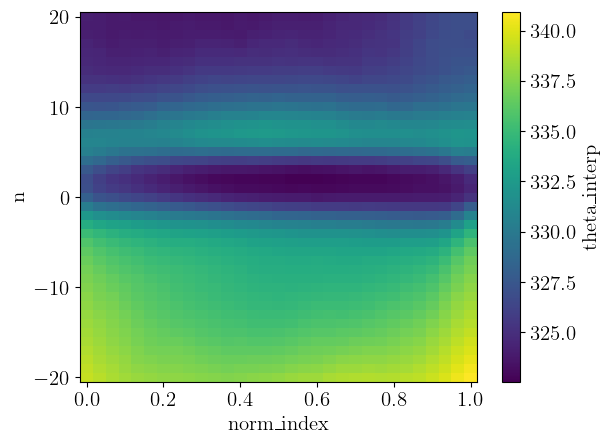

In [46]:
to_plot.T.plot()

In [39]:
to_plot.plot()

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

In [10]:
df = all_anoms["std_sm"][key].collect()

In [11]:
df.with_columns(z_interp_grad=central_diff("z_interp").over("time", "is_polar", "norm_index"))

time,is_polar,norm_index,n,z_interp,z_interp_grad
datetime[ms],bool,f64,f64,f64,f64
1969-01-01 00:00:00,false,0.0,-17.0,-1.017027,-0.069871
1969-01-01 00:00:00,false,0.0,-16.0,-1.086898,-0.142792
1969-01-01 00:00:00,false,0.0,-15.0,-1.159819,-0.136178
1969-01-01 00:00:00,false,0.0,-14.0,-1.223075,-0.099945
1969-01-01 00:00:00,false,0.0,-13.0,-1.259764,-0.047397
…,…,…,…,…,…
2020-12-31 18:00:00,true,1.0,16.0,1.322366,0.140709
2020-12-31 18:00:00,true,1.0,17.0,1.394068,0.145857
2020-12-31 18:00:00,true,1.0,18.0,1.468223,0.150624


## does it work?

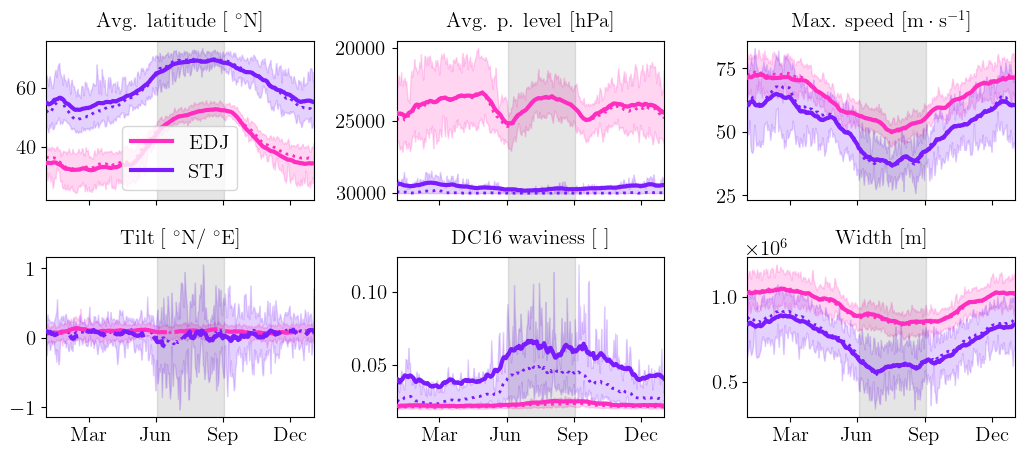

In [ ]:
data_vars = [
    "mean_lat",
    "mean_lev",
    "s_star",
    "tilt",
    "wavinessDC16",
    "width",
]
_ = plot_seasonal(
    props_ctrl, data_vars, nrows=2, ncols=3, clear=False, save=False,
)

data_vars = [
    "mean_lat",
    "mean_lev",
    "s_star",
    "tilt",
    "wavinessDC16",
    "width",
]
_ = plot_seasonal(
    props_dobl, data_vars, nrows=2, ncols=3, clear=False, save=False,
)

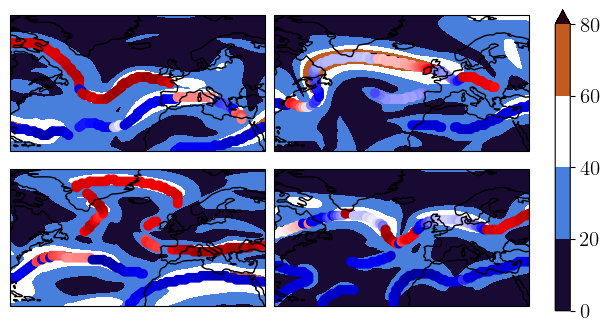

In [ ]:
nx, ny = 2, 2
clu = Clusterplot(nx, ny, region=get_region(dh.da))
t = np.sort(np.atleast_1d(np.random.randint(len(dh.da.time), size=nx * ny)))
clu.add_contourf(dh.da["s"][t])
huh = pl.Series(None, dh.da.time[t].values).cast(pl.Datetime("ms")).rename("time").to_frame().join(jets_ctrl, on="time").sort("time", "jet ID")
for i, (_, jet_) in enumerate(huh.group_by("time", maintain_order=True)):
    x, y, c = jet_[["lon", "lat", "is_polar"]]
    clu.axes[i].scatter(x - clu.central_longitude, y, c=c, vmin=0, vmax=1, cmap=colormaps.BlWhRe)

100%|██████████| 12/12 [00:29<00:00,  2.45s/it]


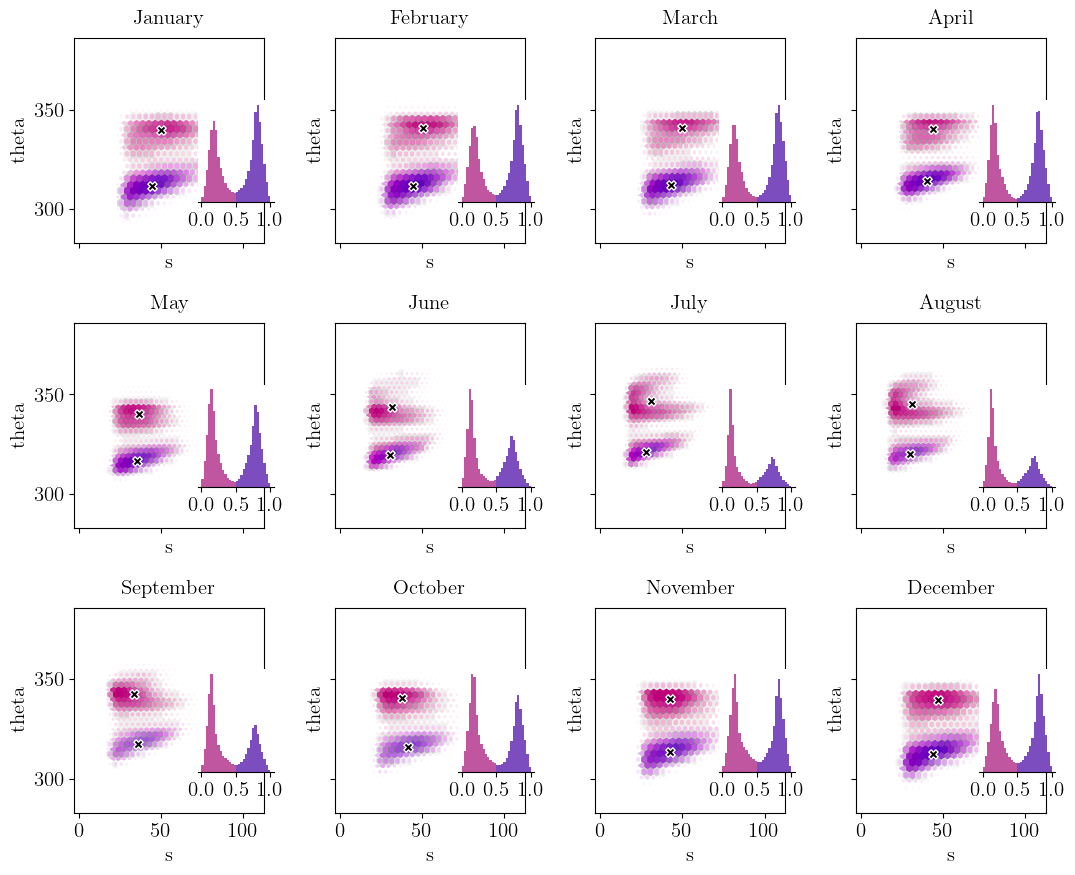

In [42]:
xys = []
all_jets = jets

xys = np.array(xys)
fig, axes = plt.subplots(3, 4, figsize=(11, 9), tight_layout=True, sharex="all", sharey="all")
axes = axes.ravel()
pair = ["s", "theta", "is_polar"]
cmap = LinearSegmentedColormap.from_list("pinkredpurple", [COLORS[2], COLORS_EXT[10], COLORS[1]])
bins = np.linspace(0, 1, 31)
for month in trange(1, 13):
    ax = axes[month - 1]
    X = extract_features(all_jets, pair, season=month)
    probas = X[pair[2]]
    center_stj = X.filter(pl.col("is_polar") < 0.3).mean()
    center_edj = X.filter(pl.col("is_polar") > 0.7).mean()
    X1D = X["is_polar"]
    
    im1 = ax.hexbin(X[pair[0]], X[pair[1]], cmap=colormaps.gray_r, gridsize=25)
    im2 = ax.hexbin(X[pair[0]], X[pair[1]], C=probas, cmap=colormaps.gray_r, gridsize=25)
    
    plt.draw()
        
    offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
    offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
    mask12 = np.isin(offsets1, offsets2)
    colors = cmap(im2.get_array())
    colors = rgb_to_hsv(colors[:, :3])
    min_s, max_s = 0., 1.0
    min_v, max_v = 0.75, 1.
    scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
    f = lambda x: np.sqrt(x)
    colors[:, 1] = min_s + scaling * (max_s - min_s)
    colors[:, 2] = max_v - scaling * (max_v - min_v)
    colors = hsv_to_rgb(colors)
    im2.set_array(None)
    im2.set_facecolor(colors)
    # im2.set_linewidths(0.2)
    im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
    im2.set_edgecolor(colormaps.greys(scaling))
    im2 = ax.add_collection(im2)
        
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 
        
    ax.set_title(MONTH_NAMES[month - 1])
    ax.scatter(*pl.concat([center_stj, center_edj])[pair[:2]].to_numpy().T, facecolor="black", edgecolor="white", marker="X", linewidths=1, s=45)
    iax = ax.inset_axes([0.65, 0.2, 0.4, 0.5])
    X1D = np.clip(X1D, 0, 1)
    iax.hist(X1D, bins=bins, alpha=0.5, color="black")
    iax.hist(X1D[probas > 0.5], bins=bins, alpha=0.5, color=COLORS[1])
    iax.hist(X1D[probas < 0.5], bins=bins, alpha=0.5, color=COLORS[2])
    iax.set_xticks([0, 0.5, 1])
    iax.set_yticks([])
    iax.spines[["left", "right", "top"]].set_visible(False)
    plt.draw()
# fig.savefig(f"{FIGURES}/jet_detection_demo/gmix_demo")

## next section